### 1. INTRO

#### What is GVA?

Gross Value Added (GVA) is a measure of the increase in the value of the economy due to the production of goods and services. It is measured at current basic prices, which include the effect of inflation, excluding taxes (less subsidies) on products (for example, Value Added Tax). GVA plus taxes (less subsidies) on products is equivalent to Gross Domestic Product (GDP).

Regional estimates of GVA are measured using the income approach, which involves adding up the income generated by resident individuals or corporations in the production of goods and services. ([source](http://webarchive.nationalarchives.gov.uk/20160106143511/http://www.ons.gov.uk/ons/dcp171778_388340.pdf))

#### Dataset & goals of the project

The dataset has been downloaded from the [Office for National Statistics website](https://www.ons.gov.uk/economy/grossvalueaddedgva/datasets/regionalgrossvalueaddedincomeapproach) and contains the following data:

* Table 1: Gross Value Added (Income Approach) at current basic prices
* Table 2: Gross Value Added (Income Approach) per head of population at current basic prices
* Table 3: Gross Value Added (Income Approach) per head indices
* Table 4: Growth in Gross Value Added (Income Approach)
* Table 5: Growth in Gross Value Added (Income Approach) per head of population
* Table 6: Gross Value Added (Income Approach) by SIC07 industry at current basic prices
* Table 7: Compensation of Employees (CoE) by SIC07 industry at current basic prices
* Table 8: Mixed Income by SIC07 industry at current basic prices
* Table 9: Rental Income by SIC07 industry at current basic prices
* Table 10: Non-Market Capital Consumption by SIC07 industry at current basic prices
* Table 11: Holding Gains by SIC07 industry at current basic prices
* Table 12: Gross Trading Profits by SIC07 industry at current basic prices
* Table 13: Gross Trading Surplus by SIC07 industry at current basic prices
* Table 14: Taxes on Production by SIC07 industry at current basic prices
* Table 15: Subsidies on Production by SIC07 industry at current basic prices

The goal of the excersise is to analyse how the current basic price for the GVA in Bath and the surrounding area has historically varied, and whether an accurate prediction can be made for future values using a statistical regression.

I plan to use data from tab 1 as a target for my regression model and data from tabs 4 & 7-15 as explanatory features. Data in remaining tabs seem to be somewhat repetitive, only calculated in a different way - so using them would be reduntant and could lead to multicollinearity problems.

### 2. EXPLORATORY DATA ANALYSIS

Initially I wanted to use indicators for every industry for the region however it quickly turned out it's a quite a bit of work to put the data together and would consume a lot of time out of my 6 hours assigned. I decided then to start with a simpler model that uses local totals as the features, to be expanded if it doesn't bring satisfactory results and if time permits.

In [4]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import itertools
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [143]:
#data = pd.read_csv("/Users/Mags/Desktop/bath_data2.csv")

data = pd.read_excel("/Users/Mags/Desktop/bath_data.xlsx")
data.head(2)

,Name,NUTS code,Region name,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,GVA_Bath,UKK12,"Bath and North East Somerset, North Somerset a...",7985,8521.0,8718.0,9312.0,10219.0,10870.0,11945.0,...,13519.0,14322.0,15042,14745,15642.0,15816.0,15885.0,16583.0,17630.0,17923.0
1,Growth_in_GVA_Bath,UKK12,"Bath and North East Somerset, North Somerset a...",-,6.7,2.3,6.8,9.7,6.4,9.9,...,2.4,5.9,5,-2,6.1,1.1,0.4,4.4,6.3,1.7


In [144]:
#dropping unecessary columns:
data = data.drop(["NUTS code", "Region name"], axis=1)
#resetting index:
data = data.set_index(['Name'])
data.index.name = None
data.head()

,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
GVA_Bath,7985,8521.0,8718.0,9312.0,10219.0,10870.0,11945.0,12426,13201.0,13519.0,14322.0,15042,14745,15642.0,15816.0,15885.0,16583.0,17630.0,17923.0
Growth_in_GVA_Bath,-,6.7,2.3,6.8,9.7,6.4,9.9,4,6.2,2.4,5.9,5,-2,6.1,1.1,0.4,4.4,6.3,1.7
CoE_Bath,4128,4456.0,4722.0,5095.0,5760.0,6082.0,6821.0,7121,7640.0,7928.0,8220.0,8506,8704,9041.0,9077.0,8972.0,9169.0,9595.0,9819.0
Mix_Inc_Bath,459,565.0,585.0,639.0,603.0,634.0,648.0,691,709.0,753.0,725.0,791,751,742.0,732.0,857.0,864.0,872.0,895.0
Rent_Inc_Bath,1225,1345.0,1416.0,1539.0,1631.0,1688.0,1777.0,1805,1860.0,1882.0,1989.0,2105,1789,1873.0,1957.0,2073.0,2144.0,2278.0,2333.0


In [145]:
#transposing dataframe for easier analysis
data = data.T
data.head()

,GVA_Bath,Growth_in_GVA_Bath,CoE_Bath,Mix_Inc_Bath,Rent_Inc_Bath,Cap_Con_Bath,Hold_Gains_Bath,GTP_Bath,GTS_Bath,Tax_Bath,Subs_Bath
1997,7985,-,4128,459,1225,214,-9,1834,20,121,-7
1998,8521,6.7,4456,565,1345,209,-6,1804,19,133,-8
1999,8718,2.3,4722,585,1416,216,-16,1642,22,139,-6
2000,9312,6.8,5095,639,1539,226,-25,1668,27,155,-6
2001,10219,9.7,5760,603,1631,254,-23,1796,25,164,-9


In [146]:
#examine the df:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 1997 to 2015
Data columns (total 11 columns):
GVA_Bath              19 non-null object
Growth_in_GVA_Bath    19 non-null object
CoE_Bath              19 non-null object
Mix_Inc_Bath          19 non-null object
Rent_Inc_Bath         19 non-null object
Cap_Con_Bath          19 non-null object
Hold_Gains_Bath       19 non-null object
GTP_Bath              19 non-null object
GTS_Bath              19 non-null object
Tax_Bath              19 non-null object
Subs_Bath             19 non-null object
dtypes: object(11)
memory usage: 1.8+ KB


In [148]:
#changing data to numeric:
data = data.apply(pd.to_numeric, errors='coerce')

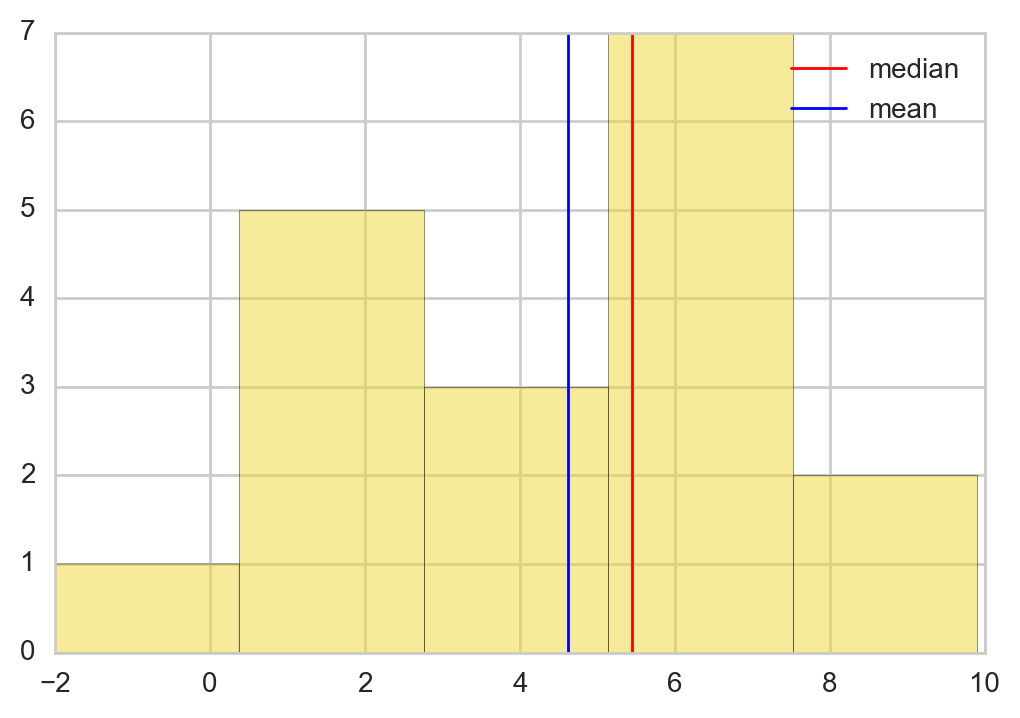

In [161]:
#missing values:

#there is one missing value in Growth_in_GVA_Bath columns - no data for year 1997. 
#let's set the missing value to Nan look at distribution of values in this column:

data.replace('-',np.NaN, inplace=True)
s = data.Growth_in_GVA_Bath
s = s.dropna()
plt.hist(s,
         bins=5,
         alpha=0.5,
         color='#EDD834')
plt.axvline(data.Growth_in_GVA_Bath.median(), color='r', linestyle='solid', linewidth=1, label = 'median')
plt.axvline(data.Growth_in_GVA_Bath.mean(), color='b', linestyle='solid', linewidth=1, label = 'mean')
plt.legend()
plt.show()


In [151]:
#basic statistics:
data.describe()

,GVA_Bath,Growth_in_GVA_Bath,CoE_Bath,Mix_Inc_Bath,Rent_Inc_Bath,Cap_Con_Bath,Hold_Gains_Bath,GTP_Bath,GTS_Bath,Tax_Bath,Subs_Bath
count,19.000000,18.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,13173.894737,4.627778,7413.473684,711.315789,1826.789474,347.315789,-30.894737,2721.473684,31.473684,201.842105,-29.736842
std,3173.707487,3.148446,1861.927954,116.358666,303.301936,99.671713,19.436205,841.099107,10.259784,49.233303,18.214287
min,7985.000000,-2.000000,4128.000000,459.000000,1225.000000,209.000000,-73.000000,1642.000000,19.000000,121.000000,-49.000000
25%,10544.500000,NaN,5921.000000,636.500000,1659.500000,260.500000,-46.500000,1930.500000,25.000000,168.000000,-46.000000
50%,13519.000000,NaN,7928.000000,725.000000,1860.000000,354.000000,-25.000000,2573.000000,28.000000,198.000000,-39.000000
75%,15729.000000,NaN,9006.500000,772.000000,2031.000000,435.000000,-15.000000,3345.000000,38.500000,247.000000,-10.500000
max,17923.000000,9.900000,9819.000000,895.000000,2333.000000,487.000000,-6.000000,4281.000000,53.000000,280.000000,-6.000000


In [156]:
data.head()

,GVA_Bath,Growth_in_GVA_Bath,CoE_Bath,Mix_Inc_Bath,Rent_Inc_Bath,Cap_Con_Bath,Hold_Gains_Bath,GTP_Bath,GTS_Bath,Tax_Bath,Subs_Bath
1997,7985.0,NaN,4128.0,459.0,1225.0,214.0,-9.0,1834.0,20.0,121.0,-7.0
1998,8521.0,6.7,4456.0,565.0,1345.0,209.0,-6.0,1804.0,19.0,133.0,-8.0
1999,8718.0,2.3,4722.0,585.0,1416.0,216.0,-16.0,1642.0,22.0,139.0,-6.0
2000,9312.0,6.8,5095.0,639.0,1539.0,226.0,-25.0,1668.0,27.0,155.0,-6.0
2001,10219.0,9.7,5760.0,603.0,1631.0,254.0,-23.0,1796.0,25.0,164.0,-9.0
